# Imports

In [2]:
#!pip install -U scikit-learn

In [3]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [4]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [5]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [6]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [7]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [8]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[16.33490822 16.339115   16.33494898 ...  5.13175959 14.72583426
  5.13262715]
[18.69052255 18.69533598 18.69056919 ...  5.8717972  16.84940825
  5.87278987]
[1.         1.         1.         ... 0.99982021 1.         0.99982047]
(5999,)


### Multinomial Sampling

In [9]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [10]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.86765, -8.78582, -4.4551697), (86.11996, 6.2811418, 91.212456), (83.661, -8.798424, 1.4792907), (75.019585, 0.66553295, 3.7841394), (76.5117, 5.0095077, 81.60506), (79.3094, 7.138877, 94.46298), (81.33114, 7.138877, 93.62556), (91.82512, -3.5589852, 2.918233), (88.470345, 7.138877, 84.809364), (75.0, -4.1574683, 97.756), (75.0, -1.6554987, 98.642876), (80.11056, -8.722893, -1.8758512), (85.83345, 7.5075808, 89.07097), (75.01873, 0.66553295, 3.7831361), (81.886826, -8.535009, -4.704521), (85.58071, 6.2811418, 91.78071), (77.408165, 8.348472, 92.52952), (78.45161, -8.760632, -5.191751), (78.57923, 8.348472, -7.2157335), (81.614365, 8.722893, -0.018805576), (75.03608, -1.3272538, 81.29398), (91.14433, -2.3044074, -2.3972287), (85.16494, -8.672658, 2.1900322), (81.96831, 8.798424, 86.84282), (76.058136, 7.9794145, -1.1781324), (63.0, -4.303499, -12.67593), (90.52928, 5.670694, 68.3), (75.0, -1.9813722, 3.5740402), (78.92292, -7.328478, 81.405594), (86.24584, 6.7292814, -5.3067026), (7

# KNN

In [11]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.86765, -8.78582, -4.4551697], [86.11996, 6.2811418, 91.212456], [83.661, -8.798424, 1.4792907], [75.019585, 0.66553295, 3.7841394], [76.5117, 5.0095077, 81.60506], [79.3094, 7.138877, 94.46298], [81.33114, 7.138877, 93.62556], [91.82512, -3.5589852, 2.918233], [88.470345, 7.138877, 84.809364], [75.0, -4.1574683, 97.756], [75.0, -1.6554987, 98.642876], [80.11056, -8.722893, -1.8758512], [85.83345, 7.5075808, 89.07097], [75.01873, 0.66553295, 3.7831361], [81.886826, -8.535009, -4.704521], [85.58071, 6.2811418, 91.78071], [77.408165, 8.348472, 92.52952], [78.45161, -8.760632, -5.191751], [78.57923, 8.348472, -7.2157335], [81.614365, 8.722893, -0.018805576], [75.03608, -1.3272538, 81.29398], [91.14433, -2.3044074, -2.3972287], [85.16494, -8.672658, 2.1900322], [81.96831, 8.798424, 86.84282], [76.058136, 7.9794145, -1.1781324], [63.0, -4.303499, -12.67593], [90.52928, 5.670694, 68.3], [75.0, -1.9813722, 3.5740402], [78.92292, -7.328478, 81.405594], [86.24584, 6.7292814, -5.3067026], [7

In [12]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [13]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  25


Number of nodes: 50
Number of edges: 673


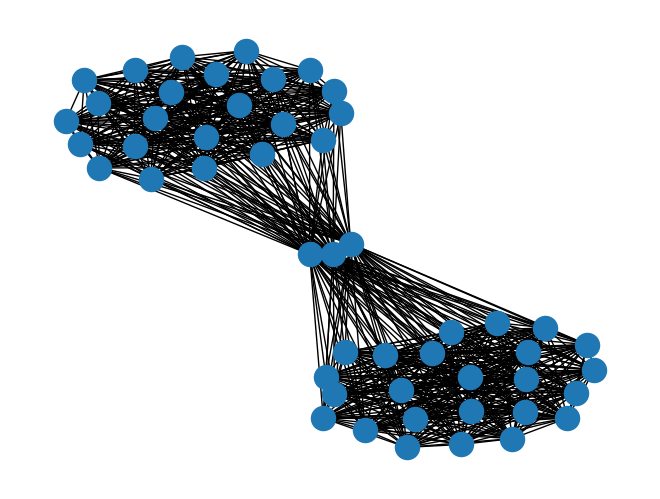

In [14]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [15]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [40]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean

#construction du fi
fi = np.random.randint(100, size=(50, 1))
for i in range(np.size(inclusion_score,0)):
    fi[i] = np.mean(inclusion_score[i][:])
    
fj = np.random.randint(100, size=(50, 1))
for i in range(np.size(inclusion_score,0)):
    fj[i] = np.mean(inclusion_score[i][:])

# f1i = np.mean(inclusion_score)
# f1j = np.mean(inclusion_score)
S = np.random.randint(100, size=(50, 50))
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

for i in range(np.size(fi,0)):
    for j in range(np.size(fj, 0)): 
        wq_fi = wq*fi[i]
        wk_fj = wk*fj[i]
        wq_wk = vector(np.matmul(wk_fj, wq_fi))
        sum_wq_wk = 0
        for k in range(np.size(fj, 0)):
            sum_wq_wk += np.exp(np.matmul(wk*fj[k],wq_fi))
        print (np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
        S[i][j] = np.exp(wq_wk)/sum_wq_wk


[[inf]]


C:\Users\basti\AppData\Local\Temp\ipykernel_7936\1848186835.py:32: RuntimeWarning: overflow encountered in exp
  sum_wq_wk += np.exp(np.matmul(wk*fj[k],wq_fi))
C:\Users\basti\AppData\Local\Temp\ipykernel_7936\1848186835.py:33: RuntimeWarning: overflow encountered in exp
  print (np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
C:\Users\basti\AppData\Local\Temp\ipykernel_7936\1848186835.py:34: RuntimeWarning: overflow encountered in exp
  S[i][j] = np.exp(wq_wk)/sum_wq_wk
C:\Users\basti\AppData\Local\Temp\ipykernel_7936\1848186835.py:34: RuntimeWarning: invalid value encountered in divide
  S[i][j] = np.exp(wq_wk)/sum_wq_wk


ValueError: setting an array element with a sequence.

### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh